In [1]:
import pandas as pd
import numpy as np
import scipy.stats as statspy

import plotly.plotly as ply
import plotly.tools as ply_t
import plotly.graph_objs as go
import fantasy as f
import seaborn as sns

from jsonDB import *

jql = jsonDB('fantasy.db')

league = 'Baseball_17'
team = "You're a Gyrok"
stats = jql.select('game type',jql.select('league',league,'schema'),0,'values','values',1,'values','values',where=('name','"*"','name'))
weeks = list(range(1,len(jql.select('league',league,'teams',0,'Season'))+1))
scored = jql.select('game type',jql.select('league',league,'schema'),0,'values','values',1,'values','values',where=('name','"*"','scored'))

In [2]:
data = []
loc = [(1,1),(1,2),(1,3),(1,4),(1,5),(2,1),(2,2),(2,3),(2,4),(2,5)]
fig = []
fig = ply_t.make_subplots(rows=5,cols=2,shared_xaxes=True)

for ndx,stat in enumerate(stats):

    scores = scored[ndx]*np.array([jql.select('league',league,'teams',where=('Name','"*"=="{}"'.format(name),stat)) for name in jql.select('league',league,'teams',where=('Name','"*"','Name'))])
    
    fig.append_trace(   go.Scatter( x=weeks + weeks[::-1],
                        y=[min([scr[ndxp-1] for scr in scores]) for ndxp in weeks]+[max([scr[ndxp-1] for scr in scores]) for ndxp in weeks][::-1],
                        name='League Range',
                        fill='tozerox',
                        fillcolor='rgba(0,50,255,0.25)',
                        line=go.Line(color='transparent'),
                        showlegend=(loc[ndx]==(1,1))),
                        loc[ndx][1],loc[ndx][0])
    
    fig.append_trace(   go.Scatter( x=weeks + weeks[::-1],
                        y=[np.percentile([scr[ndxp-1] for scr in scores],25) for ndxp in weeks]+[np.percentile([scr[ndxp-1] for scr in scores],75) for ndxp in weeks][::-1],
                        name='League IQR',
                        fill='tozerox',
                        fillcolor='rgba(0,50,255,0.50)',
                        line=go.Line(color='transparent'),
                        showlegend=(loc[ndx]==(1,1))),
                        loc[ndx][1],loc[ndx][0])
    
    fig.append_trace(   go.Scatter( x=weeks,
                        y=[np.median([scr[ndxp-1] for scr in scores]) for ndxp in weeks],
                        name='League Median',
                        line=go.Line(color='rgb(0,0,0)'),
                        mode='lines',
                        showlegend=(loc[ndx]==(1,1))),
                        loc[ndx][1],loc[ndx][0])
    
    fig.append_trace(   go.Scatter( x=weeks,
                        y=scored[ndx]*np.array(jql.select('league',league,'teams',where=('Name','"*"=="{}"'.format(team),stat))),
                        name=team,
                        line=go.Line(color='rgb(255,165,0)'),
                        showlegend=(loc[ndx]==(1,1))),
                        loc[ndx][1],loc[ndx][0])

fig['layout'].update( title= team + ' Vs Rest of League',
                           xaxis={'title': 'Week','anchor':'y9','domain':[0,0.45]},
                           xaxis2={'title': 'Week','anchor':'y10'},
                           yaxis={'title':'R','anchor':'y1','domain':[0.848,1]},
                           yaxis2={'title':'W'},
                           yaxis3={'title':'HR'},
                           yaxis4={'title':'SV'},
                           yaxis5={'title':'RBI'},
                           yaxis6={'title':'K'},
                           yaxis7={'title':'SB'},
                           yaxis8={'title':'ERA'},
                           yaxis9={'title':'AVG'},
                           yaxis10={'title':'WHIP'})
    
plot_url1 = ply.plot(fig,auto_open=False,filename='Vs Average')

This is the format of your plot grid:
[ (1,1) x1,y1 ]   [ (1,2) x2,y2 ] 
[ (2,1) x1,y3 ]   [ (2,2) x2,y4 ] 
[ (3,1) x1,y5 ]   [ (3,2) x2,y6 ] 
[ (4,1) x1,y7 ]   [ (4,2) x2,y8 ] 
[ (5,1) x1,y9 ]   [ (5,2) x2,y10 ]



In [3]:
lw = {}
ap = {}
no = {}

next_o = jql.select('league',league,'teams',where=('Name','"*"=="{}"'.format(team),'Schedule'))[0][weeks[-1]]

for ndx,stat in enumerate(stats):
    lw_league = [a[-1][stat] for a in jql.select('league',league,'teams',where=('Season','','Season'))]
    lw_me = jql.select('league',league,'teams',where=('Name','"*"=="{}"'.format(team),stat))[-1]
    lw[stat] = np.abs((100 if scored[ndx] == -1 else 0)-statspy.percentileofscore(lw_league,lw_me))
    ap[stat] = np.mean([np.abs((100 if scored[ndx] == -1 else 0)-statspy.percentileofscore(
        [a[week-1][stat] for a in jql.select('league',league,'teams',where=('Season','','Season'))],
        jql.select('league',league,'teams',where=('Name','"*"=="{}"'.format(team),stat))[week-1])) for week in weeks])
    no[stat] = np.mean([np.abs((100 if scored[ndx] == -1 else 0)-statspy.percentileofscore(
        [a[week-1][stat] for a in jql.select('league',league,'teams',where=('Season','','Season'))],
        jql.select('league',league,'teams',where=('Name','"*"=="{}"'.format(next_o),stat))[week-1])) for week in weeks])
    
df1 = pd.DataFrame(data={'Average':ap,'Last Week':lw,next_o:no},index=stats)[['Average','Last Week',next_o]]
cm = sns.light_palette("green", as_cmap=True)

df1 = df1.style.background_gradient(cmap=cm)

In [4]:
schedule = f.get_sch(league)

In [5]:
def plus_minus(val):
    color = 'red' if val < -0.005 else 'green' if val > 0.005 else 'black'
    return 'color: %s' % color

odds_series = [f.get_odds(league,week=week) for week in weeks]

delta = (odds_series[-1]-odds_series[-2]).rename(index=str, columns={col: 'delta '+col for col in odds_series[-1].columns.values.tolist()})
#.style.background_gradient(cmap=cm)
this_week = odds_series[-1]

df2 = (pd.concat([this_week,delta],axis=1)*100).style.format("{:.2f}%".format).applymap(plus_minus,subset=['delta ' + col for col in odds_series[-1].columns.values.tolist()]).background_gradient(cmap=cm,subset=[col for col in odds_series[-1].columns.values.tolist()])

In [6]:
fig = [go.Scatter(x=weeks,
            y=[week[col][team] for week in odds_series],
            name=col,
            mode='lines') for col in list(odds_series[0])]

plot_url2 = ply.plot(fig, auto_open=False, filename='New Test')

In [7]:
hth = f.new_odds(league)

Me_vs = dict(hth[team])
Me_vs.pop('')
Me_vs = {key: Me_vs[key][0] for key in Me_vs}

avg={key: 10-val for key,val in f.avg_prob(league).items()}
weeks_left = len(jql.select('league',league,'teams',0,'Schedule'))-len(jql.select('league',league,'teams',0,'Season'))
est_rec = f.predict_record(schedule,{key: avg for key in avg.keys()},weeks_left)
{key: val-weeks_left*10/2 for key,val in est_rec.items()}

wins = f.make_w_l(league,False)
record = f.predict_record(schedule,hth,len(jql.select('league',league,'teams',0,'Season'))-len(jql.select('league',league,'teams',0,'Schedule')))
{team: wins[team]-record[team][0] for team in wins.keys()}

df3 = pd.DataFrame(data={team+' Vs': Me_vs,'Strength of Schedule (proj. games)': {key: val-weeks_left*10/2 for key,val in est_rec.items()}, 'Over/Under Achievers (games)': {team: wins[team]-record[team][0] for team in wins.keys()}}).style.format('{:.2f}'.format).applymap(plus_minus, subset=['Strength of Schedule (proj. games)','Over/Under Achievers (games)'])

In [8]:
with open('report.html','w') as report:
    report.write('''<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h1>Fantasy Baseball Report</h1>

        <!-- *** Section 1 *** --->
        <h3>Percentile Scoring</h3>
        ''' + df1.render().replace('<table ','<table class="table table-striped" ') + '''
        <h3>Scoring vs Range</h2>
        <iframe width="750" height="1000" frameborder="0" seamless="seamless" scrolling="no" \
src="''' + plot_url1 + '''.embed?width=750&height=1000"></iframe>
        
        <!-- *** Section 2 *** --->
        <h3>This Week's Odds</h3>
        ''' + df2.render().replace('<table ','<table class="table table-striped" ') + '''
        <h3>My Probabilities Over Time</h3>
        <iframe width="750" height="500" frameborder="0" seamless="seamless" scrolling="no" \
src="''' + plot_url2 + '''.embed?width=750&height=500"></iframe>
        <h3>Regression Watch</h3>
        ''' + df3.render().replace('<table ','<table class="table table-striped" ') + '''
        
    </body>
</html>''')

In [9]:
home = 'You\'re a Gyrok'
away = 'Josh\'s Team'
stat = 'RBI'
ovrd = False

means = f.get_mean(league,ovrd)
stdevs = f.get_std(league,ovrd)
maxes = f.get_max(league,ovrd)

f.poisson_odds(means[home][stat],means[away][stat],maxes[home][stat],maxes[away][stat])

0.36118208838542915

In [10]:
f.normal_odds(means[home][stat],means[away][stat],stdevs[home][stat],stdevs[away][stat])

0.37635128197594858

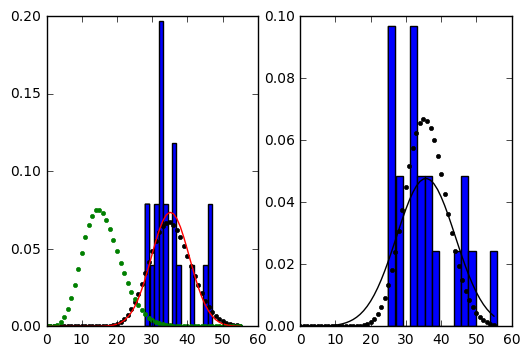

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import nbinom

stat = 'R'
r =100
plt.subplot(1,2,1)

plt.plot(poisson.pmf(range(max(maxes[home][stat],maxes[away][stat])),means[home][stat]),'k.')
plt.plot(nbinom.pmf(range(max(maxes[home][stat],maxes[away][stat])),19.16,0.545),'g.')
plt.plot(norm.pdf(range(max(maxes[home][stat],maxes[away][stat])),means[home][stat],stdevs[home][stat]),'r')

plt.hist(jql.select('league',league,'teams',where=('Name','"*"=="You\'re a Gyrok"',stat)),normed=True,bins=15)

plt.subplot(1,2,2)

plt.plot(poisson.pmf(range(max(maxes[home][stat],maxes[away][stat])),means[away][stat]),'k.')
plt.plot(norm.pdf(range(max(maxes[home][stat],maxes[away][stat])),means[away][stat],stdevs[away][stat]),'k')

plt.hist(jql.select('league',league,'teams',where=('Name','"*"=="Josh\'s Team"',stat)),normed=True,bins=15)

plt.show()

In [67]:
a = jql.select('league',league,'teams',where=('Name','"*"=="You\'re a Gyrok"','R'))
mu = np.mean(a)
var = np.var(a)
print(mu/(var+mu),(mu**2)/(var+mu))

0.545151409406 19.1620720406
